# Relative Binding Free Energy Calculations

Authors:
- Aditi Lalla, CADD Seminar 2024-25, Universität des Saarlandes
- Raquel López-Ríos de Castro, 2024-25, Charité Berlin

__Note__

This talktorial was designed to be run on Linux; for other Operating Systems please use the Google Colab link given in the Practical section. However, running the final calculations is only advisable on an HPC cluster.

## Aim of this talktorial

This talktorial aims to explain the concept of relative binding free energy (RBFE), why we use it in CADD, and to demonstrate how we use it with the help of [OpenFE]("https://docs.openfree.energy/en/stable/index.html"). OpenFE is a freely available open-source toolkit that performs free energy calculations.

## Contents in *Theory*

- What is *Free Energy*?
    - Use in CADD
    - Absolute vs Relative binding free energy
- Thermodynamic Cycle
- Alchemical Transformation
- Ligand Similarity

## Contents in *Practical*

- Setup and Installation on Google Colab
- Input and Output
- Protein Structure
- Ligand Compounds
  - View Structures
  - Map ligands
  - Create Ligand Mapping Network
- Prepare for Calculation
  - Define the Chemical Systems
  - Define RBFE Simulation Protocol
- Perform the RBFE Calculation
  - Create Transformation
  - Run
- Analyse Results

## References

* Koby SB, Gutkin E, Patel S, Kurnikova M. An Automated On-The-Fly Optimization of Resource Allocation for High-Throughput Protein-Ligand Binding Free Energy Simulations. [*ChemRxiv*, 2023. DOI: 10.26434/chemrxiv-2023-rtpsz](https://chemrxiv.org/engage/chemrxiv/article-details/64c9a059ce23211b20f603fd)
* Chodera JD and Shirts MR. Replica exchange and expanded ensemble simulations as Gibbs multistate: Simple improvements for enhanced mixing. [*J. Chem. Phys.*, 135:194110, 2011. DOI:10.1063/1.3660669](https://pubs.aip.org/aip/jcp/article/135/19/194110/189775/Replica-exchange-and-expanded-ensemble-simulations)
* Friedrichs MS, Eastman P, Vaidyanathan V, Houston M, LeGrand S, Beberg AL, Ensign DL, Bruns CM, and Pande VS. Accelerating molecular dynamic simulations on graphics processing unit. [*J. Comput. Chem.*, 30:864, 2009. DOI: 10.1002/jcc.21209](https://onlinelibrary.wiley.com/doi/10.1002/jcc.21209)
* Eastman P and Pande VS. OpenMM: A hardware-independent framework for molecular simulations. [*Comput. Sci. Eng.* 12:34, 2010. DOI: 10.1109/MCSE.2010.27](https://dl.acm.org/doi/abs/10.1109/MCSE.2010.27)
* Eastman P and Pande VS. Efficient nonbonded interactions for molecular dynamics on a graphics processing unit. [J. Comput. Chem. 31:1268, 2010. DOI: 10.1002/jcc.21413](https://onlinelibrary.wiley.com/doi/full/10.1002/jcc.21413)
* Eastman P and Pande VS. Constant constraint matrix approximation: A robust, parallelizable constraint method for molecular simulations. [J. Chem. Theor. Comput. 6:434, 2010. DOI: 10.1021/ct900463w](https://pubs.acs.org/doi/full/10.1021/ct900463w)
* [TeachOpenCADD MD Simulations Talktorial](https://projects.volkamerlab.org/teachopencadd/talktorials/T019_md_simulation.html)
* [OpenFreeEnergy Documentation](https://docs.openfree.energy/en/stable/index.html)

## Theory

### What is *Free Energy*?

Free energy is a thermodynamic quantity that represents the work a system can perform while transitioning from one state to another under constant temperature and pressure. In computational drug discovery (CADD), binding free energy quantifies the favorability of a ligand binding to its target protein, making it a central concept for predicting binding affinities.

#### Use in CADD

Binding free energy calculations have become an essential tool in CADD for evaluating and prioritizing compounds. Relative Binding Free Energy (RBFE) calculations, in particular, offer a robust alternative to time-intensive molecular dynamics (MD) simulations or much less accurate machine-learning (ML) based filtering algorithms. By leveraging alchemical transformations, RBFE allows us to screen large libraries of compounds in a computationally efficient manner. These calculations yield predictions that are as accurate as MD simulations in capturing compound behavior in situ while significantly reducing computational costs and time.

This efficiency makes RBFE particularly valuable in lead optimization, where subtle modifications to a ligand structure can be rapidly assessed for their impact on binding affinity. This capacity to process large datasets in less time is transformative for high-throughput virtual screening workflows.

#### Absolute vs. Relative Binding Free Energy

Binding free energy calculations in CADD can be broadly categorized into absolute and relative approaches.

- Relative Binding Free Energy (RBFE):

  - RBFE focuses on the change in binding free energy when one ligand is modified to another, such as adding or substituting functional groups. Instead of calculating the absolute energy for each ligand, RBFE measures the difference between two similar ligands.  An RBFE cycle is depicted in part (A) of the image below.
  - This approach significantly reduces computational costs and time while maintaining accuracy, as the structural and chemical similarity between ligands minimizes the complexity of transformations.
  - RBFE is particularly useful in lead optimization, where small chemical changes to a ligand are evaluated for their impact on binding affinity.

<figure style="text-align: center;">
    <img src="https://www.researchgate.net/publication/372875380/figure/fig1/AS:11431281178806721@1691071275867/Alchemical-Thermodynamic-Cycles-for-RBFE-left-and-ABFE-right-The-arrows-determine.png" width="600"/>
    <figcaption><strong>Figure 1:</strong> Alchemical Thermodynamic Cycles for RBFE (left, A) and ABFE (right, B). The arrows determine the direction of the free energy calculations.</figcaption>
    <figcaption><strong>Source:</strong> An Automated On-The-Fly Optimization of Resource Allocation for High-Throughput Protein-Ligand Binding Free Energy Simulations, 2023, Koby et. al.</figcaption>
</figure>


- Absolute Binding Free Energy (ABFE):

  - ABFE calculations estimate the free energy of a ligand binding to a target protein from scratch, considering all possible interactions between the ligand, protein, solvent, and surrounding environment.
  - These calculations require simulating the full binding process and are more computationally intensive because they involve sampling the ligand and protein in various configurations. An ABFE cycle is depicted in part (B) of the image above.
  - While highly accurate, ABFE is generally reserved for smaller datasets or cases where high precision is critical, such as when validating experimental results.

While ABFE provides a complete picture of ligand binding, it is often impractical for large-scale virtual screening due to its computational demands. RBFE, on the other hand, offers a practical alternative by leveraging ligand similarity and thermodynamic cycles to rapidly assess binding free energy differences.

In this talktorial, we focus on RBFE as a computationally efficient tool for guiding drug discovery efforts.

### Thermodynamic Cycle

RBFE calculations rely on thermodynamic cycles to estimate the difference in binding affinities between two ligands. The attached diagram illustrates a thermodynamic cycle, which decomposes the binding free energy into two alchemical transformations: one in solution and the other in the binding site.

<figure style="text-align: center;">
    <img src="https://raw.githubusercontent.com/OpenFreeEnergy/openfe/main/docs/guide/protocols/img/rbfe_thermocycle.png" width="600"/>
    <figcaption><strong>Figure 2:</strong> Thermodynamic Cycle for RBFE calculations. The arrows determine the direction of the free energy calculations.</figcaption>
    <figcaption><strong>Source:</strong> Open Free Energy Github Resources.</figcaption>
</figure>

- **In the binding site:** The free energy change represents the transformation of ligand A to ligand B while bound to the protein target.

- **In solution:** The free energy change reflects the same transformation, but in isolation (without the protein).

By combining these two transformations, we eliminate the need to directly calculate the absolute binding free energies, which are computationally demanding. Instead, the relative binding free energy ($\Delta \Delta G_{\text{bind}}$) is derived using the equation:

#### $\Delta \Delta G_{\text{bind}} = \Delta G_{\text{site}} - \Delta G_{\text{solv}}$

This approach provides an accurate and efficient way to compare the binding affinities of structurally similar compounds.

### Alchemical Transformations

Alchemical transformations form the backbone of RBFE calculations. These involve the hypothetical, gradual conversion of one molecule into another by altering atomic or molecular properties, such as removing or adding functional groups.


<figure style="text-align: center;">
    <img src="https://docs.openfree.energy/en/v1.0.0/_images/tutorials_showcase_notebook_6_0.png" width="600"/>
    <figcaption><strong>Figure 3:</strong> Alchemical Transformation of Benzene</figcaption>
    <figcaption><strong>Source:</strong> Open Free Energy Documentation</figcaption>
</figure>

The diagram you see visualizes an alchemical transformation of benzene into substituted derivatives, showing the intermediate states through which the transformation progresses. Key aspects of this process include:

- **Intermediate states:** These are constructed to ensure a smooth transition between the initial and final states, enabling accurate free energy estimates.

- **Soft-core potentials:** These are used to prevent numerical instabilities during transformations, especially when atoms are being annihilated or created.

By employing alchemical transformations, we can simulate changes in molecular structure and compute their impact on binding affinity, even for chemically diverse compounds.

### Ligand Similarity

In CADD, ligand similarity plays a pivotal role in prioritizing compounds for RBFE calculations. Ligands that share structural or chemical similarities with a known active compound are more likely to exhibit similar binding behavior, making them ideal candidates for RBFE workflows.

Ligand similarity is typically quantified using algorithms like the **Tanimoto similarity index**, which compares the chemical fingerprints of two molecules. Clustering algorithms can further group ligands based on similarity, facilitating the selection of representative compounds for RBFE analysis.

<figure style="text-align: center;">
    <img src="https://miro.medium.com/max/1400/0*LtCn9l019IeLViyP" width="600"/>
    <figcaption><strong>Figure 4:</strong> Structural Similarity and Tanimoto Score</figcaption>
    <figcaption><strong>Source:</strong> CMBI</figcaption>
</figure>

By focusing on structurally related ligands, we can maximize the efficiency of RBFE calculations and enhance the predictive power of our models. Later in this talktorial, we will explore practical applications of ligand similarity by generating a heatmap and applying clustering techniques to analyze a ligand dataset.

As an example, here are two molecules from our ligand set that are very similar in structure:

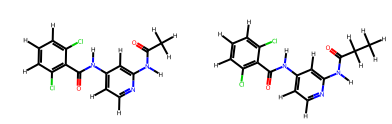

And here are two molecules from our ligand set that are significantly dissimilar in structure:

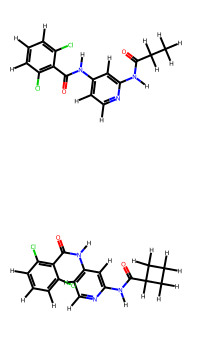

The similar molecules both have two aromatic rings, and only differ in the size of the hydrocarbon attached at the end of the second ring.

On the other hand, the two dissimilar molecules not only differ in the size of the hydrocarbon functional group, but also differ in thr number of aromatic rings.

The tanimoto similarity scores for the similar molecules will be much higher, as a result, compared to the scores for the dissimilar molecules.

It should be noted that **all** compounds in our ligand set are quite similar and all have a relatively high tanimoto similarity score (>=0.65). In practice, larger sets are used with a much wider range of structures.

## Practical

The practical notebook may be run on Jupyter Lab or on [Google Colab](https://colab.research.google.com/drive/1lhoo1Ehws1WB1dgymHFw1Cr7ybmDVvk_). For Linux users, installing [OpenFE](https://github.com/OpenFreeEnergy/openfe/releases/download/v1.2.0/OpenFEforge-1.2.0-Linux-x86_64.sh) and running this notebook on Jupyter Lab is ideal. Please note that before installing the OpenFE shell script, the system already has conda, python, and mamba available. Also note that the OpenFE installation will take place in the base conda environment.

Windows and MacOS users will need to run this section on the Google Colab link provided.

### Install libraries and create output directory

In [1]:
!mkdir outputs

mkdir: cannot create directory ‘outputs’: File exists


#### Setup and Installation on Google Colab

In [ ]:
## ONLY RUN ON GOOGLE COLAB

!pip install RDKit

In [ ]:
## ONLY RUN ON GOOGLE COLAB

!pip install biopython

In [ ]:
## ONLY RUN ON GOOGLE COLAB

!pip install py3Dmol

In [ ]:
## ONLY RUN ON GOOGLE COLAB

import os
if "COLAB_RELEASE_TAG" in os.environ:
    !pip install -q condacolab
    import condacolab
    condacolab.install_from_url("https://github.com/OpenFreeEnergy/openfe/releases/download/v1.2.0/OpenFEforge-1.2.0-Linux-x86_64.sh")

In [ ]:
## ONLY RUN ON GOOGLE COLAB

import os
if "COLAB_RELEASE_TAG" in os.environ:
    import condacolab
    import locale
    locale.getpreferredencoding = lambda: "UTF-8"
    !mkdir inputs && cd inputs && openfe fetch rbfe-tutorial
    for _ in range(3):
      # Sometimes we have to re-run the check
      try:
        condacolab.check()
      except:
        pass
      else:
        break

### Input and Output

**Input**

Our input will be:


1.   **Target Protein** - This is the protein that will be the target for our drug, which will be the ligand that has the best bond with the protein. In our example, the protein is a Tyrosine Kinase, commonly found in viral diseases.
2.   **Ligands Set** - This is a set of small molecules called ligands that all bind with and interact with our target protein. We will perform RBFE calculations on this set of ligands to find the best "fit" for our protein, thereby a potential drug candidate.

**Output**

Our output will be **RBFE Calculations** that will be performed on the set of ligands, while simulating their bonds with the protein in a solvent, mimicking real world conditions of pressure, temperature, and concentration. The analysis of this calculation will enable us to choose the best compound from our set to act as a drug to bind to our target protein.


### Protein Structure

In [ ]:
import py3Dmol

with open("inputs/tyk2_protein.pdb", "r") as file:
    pdb_data = file.read()

view = py3Dmol.view(width=800, height=600)
view.addModel(pdb_data, "pdb")
view.setStyle({"cartoon": {"color": "spectrum"}})
view.zoomTo()
view.spin(axis="y")
view.show()


### Ligand Molecules

#### Visualise Structures

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

# Extract the contents of the sdf file and visualise it
ligands_rdmol = [mol for mol in
                 Chem.SDMolSupplier("inputs/tyk2_ligands.sdf", removeHs=False)]

for ligand in ligands_rdmol:
    AllChem.Compute2DCoords(ligand)

Chem.Draw.MolsToGridImage(ligands_rdmol)

#### Ligand Similarity

In [ ]:
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
import numpy as np
import pandas as pd
from rdkit.Chem import rdmolfiles
import seaborn as sns
import matplotlib.pyplot as plt

suppl = rdmolfiles.SDMolSupplier("inputs/tyk2_ligands.sdf")
molecules = [mol for mol in suppl if mol is not None]

print(f"Loaded {len(molecules)} molecules.")

fingerprints = [AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048) for mol in molecules]

num_mols = len(fingerprints)
tanimoto_matrix = np.zeros((num_mols, num_mols))

for i in range(num_mols):
    for j in range(num_mols):
        tanimoto_matrix[i, j] = DataStructs.FingerprintSimilarity(fingerprints[i], fingerprints[j])

tanimoto_df = pd.DataFrame(tanimoto_matrix, columns=[f"Mol_{i+1}" for i in range(num_mols)],
                           index=[f"Mol_{i+1}" for i in range(num_mols)])

plt.figure(figsize=(10, 8))
sns.heatmap(tanimoto_df, annot=False, cmap="viridis")
plt.title("Tanimoto Similarity Heatmap")
plt.savefig("outputs/tanimoto_similarity.png")
plt.show()

In [ ]:
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform

# Convert similarity matrix to a distance matrix
distance_matrix = 1 - tanimoto_matrix

# Perform hierarchical clustering
linkage_matrix = linkage(squareform(distance_matrix), method='average')

# Choose a threshold to determine clusters (e.g., max distance for grouping)
threshold = 0.3  # Adjust based on your needs
clusters = fcluster(linkage_matrix, t=threshold, criterion='distance')

# Assign clusters to molecules
tanimoto_df['Cluster'] = clusters
print(tanimoto_df['Cluster'])

#### Load Molecules

##### Using RDKit

In [ ]:
import locale
locale.getpreferredencoding = lambda _: 'UTF-8'  # hack for google colab, not needed for local execution
from openfe import SmallMoleculeComponent

# Load ligands using RDKit
ligands_sdf = Chem.SDMolSupplier('inputs/tyk2_ligands.sdf', removeHs=False)

# Now pass these to form a list of Molecules
ligand_mols = [SmallMoleculeComponent(sdf) for sdf in ligands_sdf]

##### Using OpenFF Toolkit

In [ ]:
from openff.toolkit import Molecule
from openfe import SmallMoleculeComponent

# Load ligands using OpenFF toolkit
ligands_sdf = Molecule.from_file('inputs/tyk2_ligands.sdf')

# Now pass these to form a list of Molecules
ligand_mols = [SmallMoleculeComponent.from_openff(sdf) for sdf in ligands_sdf]

Using the OpenFF toolkit allows us to access properties such as the name and type of each molecule

In [ ]:
print("name: ", ligand_mols[5].name)

In [ ]:
type(ligand_mols[5].to_openff())

#### Ligand Atom Mapping

In [ ]:
from openfe.setup import LomapAtomMapper
mapper = LomapAtomMapper()
lomap_mapping = next(mapper.suggest_mappings(ligand_mols[5], ligand_mols[7]))

In [ ]:
# We can display the atom mapping in 2D by calling it
lomap_mapping

##### Visualise the mapping using OpenFE

In [ ]:
# Visualize the mapping in 3D
from openfe.utils import visualization_3D

visualization_3D.view_mapping_3d(lomap_mapping, show_atomIDs=True)

##### Visualise the mapping using Kartograf

In [ ]:
from kartograf import KartografAtomMapper
# Build Kartograf Atom Mapper
mapper = KartografAtomMapper(atom_map_hydrogens=True)

# Get Mapping
kartograf_mapping = next(mapper.suggest_mappings(ligand_mols[5], ligand_mols[7]))

In [ ]:
# We can display the atom mapping in 2D by calling it
kartograf_mapping

#### Create Ligand Mapping Network

In [ ]:
# Create network from the two molecules
import openfe
from openfe.setup.ligand_network_planning import generate_radial_network
from openfe.setup.ligand_network_planning import generate_minimal_spanning_network
from openfe.setup.ligand_network_planning import generate_lomap_network
from openfe.setup import LomapAtomMapper

# Create an MST network
mst_network = generate_minimal_spanning_network(
    ligands=ligand_mols,
    scorer=openfe.lomap_scorers.default_lomap_score,
    mappers=[LomapAtomMapper(),])

# Create a LOMAP network
lomap_network = generate_lomap_network(
    molecules=ligand_mols,
    scorer=openfe.lomap_scorers.default_lomap_score,
    mappers=[LomapAtomMapper(),])

# Create a radial, choosing the first ligand as central ligand
radial_network = generate_radial_network(
    ligands=ligand_mols[1:],
    central_ligand=ligand_mols[0],
    mappers=[LomapAtomMapper(),])

Support for third party widgets will remain active for the duration of the session. To disable support:

In [ ]:
# Visualize the MST network
from openfe.utils.atommapping_network_plotting import plot_atommapping_network

plot_atommapping_network(mst_network)

In [ ]:
# Visualize the LOMAP network
from openfe.utils.atommapping_network_plotting import plot_atommapping_network

plot_atommapping_network(lomap_network)

In [ ]:
# Visualize the radial network
from openfe.utils.atommapping_network_plotting import plot_atommapping_network

plot_atommapping_network(radial_network)

##### Alchemical Transformation Example

In [ ]:
mst_edges = [edge for edge in mst_network.edges]

# Pick an edge
edge = mst_edges[1]

# Print the smiles of the molecules and the mapping
print("molecule A smiles: ", edge.componentA.smiles)
print("molecule B smiles: ", edge.componentB.smiles)
print("molecule A name: ", edge.componentA.name)
print("molecule B name: ", edge.componentB.name)
print("map between molecule A and B: ", edge.componentA_to_componentB)

In [ ]:
edge

In [ ]:
from IPython.display import Image

# mappings can also be saved to file if required
edge.draw_to_file('outputs/tyk2_edge.png')

# load it back for visualisation
Image("outputs/tyk2_edge.png")

##### Store MST Network

In [ ]:
# Convert to graphml
with open("outputs/network_store.graphml", "w") as writer:
    writer.write(mst_network.to_graphml())

### Prepare for Calculation

#### Define the Chemical Systems

In [2]:
# First let's define the Protein and Solvent Components which we will be using
from openfe import SolventComponent, ProteinComponent
from openff.units import unit

protein = ProteinComponent.from_pdb_file('inputs/tyk2_protein.pdb')

# Note: the distance from the solute to add water is not defined here but in the
# the relevant RBFE solver method
solvent = SolventComponent(positive_ion='Na', negative_ion='Cl',
                           neutralize=True, ion_concentration=0.15*unit.molar)

In [ ]:
# Extract the relevant edge for the ligand transform in the radial graph
lig_transform = [edge for edge in mst_network.edges][1]

lig_transform

In [ ]:
# Let's create the four ChemicalSystems
from openfe import ChemicalSystem

lig_1_complex = ChemicalSystem({'ligand': lig_transform.componentA,
                                  'solvent': solvent,
                                  'protein': protein,},
                               name=lig_transform.componentA.name)
lig_1_solvent = ChemicalSystem({'ligand': lig_transform.componentA,
                                  'solvent': solvent,},
                               name=lig_transform.componentA.name)

lig_2_complex = ChemicalSystem({'ligand': lig_transform.componentB,
                                 'solvent': solvent,
                                 'protein': protein,},
                               name=lig_transform.componentB.name)
lig_2_solvent = ChemicalSystem({'ligand': lig_transform.componentB,
                                 'solvent': solvent,},
                               name=lig_transform.componentB.name)

#### Define the RBFE Simulation Protocol

In [ ]:
from openfe.protocols.openmm_rfe import RelativeHybridTopologyProtocol
from openff.units import unit

# Create the default settings
rbfe_settings = RelativeHybridTopologyProtocol.default_settings()

rbfe_settings.simulation_settings.equilibration_length = 10 * unit.picosecond # Reduce equilibration length to 10 picoseconds
rbfe_settings.simulation_settings.production_length = 50 * unit.picosecond # Reduce prodution length to 50 picoseconds

rbfe_settings.simulation_settings

In [ ]:
# Create RBFE Protocol class
rbfe_protocol = RelativeHybridTopologyProtocol(
    settings=rbfe_settings
)

### RBFE Calculations

#### Create the Transformation

In [ ]:
transformation_complex = openfe.Transformation(
            stateA=lig_1_complex,
            stateB=lig_2_complex,
            mapping=lig_transform,
            protocol=rbfe_protocol,  # use protocol created above
            name=f"{lig_1_complex.name}_{lig_2_complex.name}_complex"
        )
transformation_solvent = openfe.Transformation(
            stateA=lig_1_solvent,
            stateB=lig_2_solvent,
            mapping=lig_transform,
            protocol=rbfe_protocol,  # use protocol created above
            name=f"{lig_1_solvent.name}_{lig_2_solvent.name}_solvent"
        )

With the Transformation defined, we can move onto creating the ProtocolDAG.

The Transformation.create() method creates a directed-acyclic-graph (DAG) of computational tasks necessary for creating an estimate of the free energy difference between the two chemical systems.

In [ ]:
complex_dag = transformation_complex.create()

solvent_dag = transformation_solvent.create()

#### Run

In [ ]:
## ONLY RUN ON HPC CLUSTER

complex_unit = list(complex_dag.protocol_units)[0]

print(complex_unit)

complex_unit.run(dry=True, verbose=True)

In [ ]:
## ONLY RUN ON HPC CLUSTER

solvent_unit = list(solvent_dag.protocol_units)[0]

solvent_unit.run(dry=True, verbose=True)

### Analyse Results

#### Save Results

In [ ]:
## ONLY RUN ON HPC CLUSTER

import pathlib
# first we create the directory
transformation_dir = pathlib.Path("tyk2_json")
transformation_dir.mkdir(exist_ok=True)

# then we write out the transformations
transformation_complex.dump(transformation_dir / f"{transformation_complex.name}.json")
transformation_solvent.dump(transformation_dir / f"{transformation_solvent.name}.json")

Analyse Results using CLI

Should be done on an HPC Cluster

Analyse Results using Python API

In [ ]:
## ONLY RUN ON HPC CLUSTER

from openfe import execute_DAG

# Finally we can run the simulations
complex_path = pathlib.Path('./complex')
complex_path.mkdir()

# First the complex transformation
complex_dag_results = execute_DAG(complex_dag, scratch_basedir=complex_path, shared_basedir=complex_path)

# Next the solvent state transformation
solvent_path = pathlib.Path('./solvent')
solvent_path.mkdir()

solvent_dag_results = execute_DAG(solvent_dag, scratch_basedir=solvent_path, shared_basedir=solvent_path)

# Get the complex and solvent results
complex_results = rbfe_protocol.gather([complex_dag_results])
solvent_results = rbfe_protocol.gather([solvent_dag_results])

print(f"Complex dG: {complex_results.get_estimate()}, err {complex_results.get_uncertainty()}")
print(f"Solvent dG: {solvent_results.get_estimate()}, err {solvent_results.get_uncertainty()}")

Should be done on an HPC Cluster

#### Analysis of Example

##### Download precalculated results for analysis

In [3]:
#locale.getpreferredencoding = lambda: "UTF-8"  # hack for google colab, not needed for local execution
!openfe fetch rbfe-tutorial-results
# Extract results
!tar -xf rbfe_results.tar.gz

Fetching /home/aditi-lalla/openfeforge/lib/python3.10/site-packages/openfecli/tests/data/rbfe_results.tar.gz


##### View and Save

In [4]:
!openfe gather results/ --report dg -o final_results.tsv
import pandas as pd

# Load TSV file
df = pd.read_csv('final_results.tsv', sep='\t')

# Round numerical columns to 2 decimal places for internal data
df['DG(MLE) (kcal/mol)'] = df['DG(MLE) (kcal/mol)'].round(2)
df['uncertainty (kcal/mol)'] = df['uncertainty (kcal/mol)'].round(2)

# Sort the ligands from best to worst
df_sorted = df.sort_values(by='DG(MLE) (kcal/mol)', ascending=True)

# Style the dataframe and format numbers
styled_table = df_sorted.style.format({
    'DG(MLE) (kcal/mol)': '{:.2f}',  # Ensure 2 decimal places for this column
    'uncertainty (kcal/mol)': '{:.2f}',  # Ensure 2 decimal places for this column
}).set_table_styles(
    [{'selector': 'thead th', 'props': [('background-color', '#4CAF50'), ('color', 'white'), ('text-align', 'center')]},  # Header styling
     {'selector': 'tbody td', 'props': [('color', 'black'), ('text-align', 'center')]},  # Font set to black for readability
     {'selector': 'table', 'props': [('border-collapse', 'collapse'), ('width', '80%'), ('margin', 'auto')]},  # Table width and margins
     {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#f9f9f9')]},  # Odd row styling for alternating color
     {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#ffffff')]},  # Even row styling
     {'selector': 'tbody td', 'props': [('padding', '8px'), ('border', '1px solid #ddd')]},  # Cell padding and border
     {'selector': 'th', 'props': [('padding', '8px'), ('border', '1px solid #ddd')]},  # Header cell padding and border
     {'selector': 'thead th', 'props': [('font-weight', 'bold')]},  # Header text boldness
     {'selector': 'tbody td', 'props': [('font-size', '14px')]},  # Font size for readability
    ]
)

# Show the styled table (works best in Jupyter or notebook environments)
styled_table

,ligand,DG(MLE) (kcal/mol),uncertainty (kcal/mol)
9,lig_jmc_28,-1.25,0.08
8,lig_jmc_27,-1.10,0.10
2,lig_ejm_46,-0.98,0.05
7,lig_jmc_23,-0.68,0.09
3,lig_ejm_47,-0.10,0.10
0,lig_ejm_31,-0.09,0.05
4,lig_ejm_48,0.53,0.09
1,lig_ejm_42,0.70,0.10
5,lig_ejm_50,0.91,0.06
6,lig_ejm_43,2.00,0.20


In the table above, we have the results for $\Delta G$ or Gibbs Free Energy change (denoted by DG in the table). MLE refers to Maximum Likelihood Estimation which is a statistical method to estimate which parameters of a model make the observed data most likely. Therefore the DG(MLE) column gives us the $\Delta G$ of binding to the protein for each ligand in our set.

The uncertainty column gives us the standard error of the $\Delta G$ measurement.

The results here indicate **lig_jmc_28** as the most promising candidate for binding to our target protein - since it has the lowest $\Delta G$ of all compounds, signifying that it is most likely to bind to our target protein spontaneously/without the need for an external force.

Conversely, **lig_ejm_43** is the least promising candidate from our set since it has the highest  $\Delta G$, which means that it is unlikely to bind to our protein spontaneously and that external force or reactions will be necessary for that bond.

For ease, the table is sorted with the most favourable ligands at the top.

## Discussion

### Summary

In this talktorial, we explored the concept of Relative Binding Free Energy (RBFE) and its application in drug discovery. We began by understanding the thermodynamic principles behind free energy calculations, differentiating between absolute and relative binding free energies. We also delved into the practical application of RBFE, using the alchemical transformation approach to compute the relative affinities of different ligands to a protein target.

Through the practical section, we demonstrated the process of setting up an RBFE calculation in a Google Colab environment, preparing ligand and protein structures, defining the chemical systems, and running simulations. Finally, we analyzed the results, highlighting how RBFE calculations can be used to rank ligands based on their predicted binding affinity to the target.

### Pros and Cons

**Pros:**

* Efficiency: RBFE calculations allow for the rapid comparison of ligand binding affinities without the need for extensive docking studies for each individual ligand. This can significantly accelerate the drug discovery process, particularly in virtual screening scenarios.
* Accuracy: When performed carefully, RBFE provides reliable estimates of relative binding affinities, making it a powerful tool for ligand optimization and prioritization in early-stage drug discovery.

**Cons:**

* Computational Resources: While RBFE calculations are more efficient than full molecular dynamics simulations, they still require considerable computational power, especially when simulating large or complex systems.
* Force Field Dependence: The accuracy of RBFE calculations is highly dependent on the force field used for the simulations. The choice of force field and its parameterization can significantly affect the predicted binding energies.

### Challenges

Despite the advantages, there are several ongoing challenges and open questions in the RBFE approach:

* Current models often assume rigid ligands, which may not always reflect their behavior in real biological systems. How can we better account for the flexibility of ligands during the alchemical transformation process, especially for molecules with highly flexible or large structures?
* How can we more effectively include protein flexibility and conformational changes in RBFE calculations? This is particularly important for systems where the protein undergoes significant structural changes upon ligand binding, which may influence binding affinity.
* There remains a need for more extensive validation of force fields across a diverse range of protein-ligand systems. Are the current force fields capable of providing reliable relative binding free energies for all types of ligands and proteins?

## Quiz

You should be able to answer the following questions after doing this talktorial:

1. What is the key difference between relative and absolute binding free energy? What is the main principle of the thermodynamic cycle for RBFE calculations, and does that make RBFE calculations more preferable to ABFE calculations?
2. What are the steps involved in preparing the ligand-protein complex for RBFE calculations?
3. What is the role of alchemical transformations in estimating the binding affinity of various ligands?